In [7]:
import psycopg2
import pandas as pd
import torch
import torch.nn.functional as F

from sentence_transformers import SentenceTransformer
from psycopg2.extras import execute_values
from pgvector.psycopg2 import register_vector
from tqdm import tqdm
import matplotlib.pyplot as plt

In [65]:
# connecting to a postgres instance
conn = psycopg2.connect(
    host='localhost',
    user='postgres',
    port=5439,
    database='postgres',
    password='ManiAnu@12345'
)
conn.readonly = False
conn.autocommit = True



cursor = conn.cursor(cursor_factory = psycopg2.extras.RealDictCursor)
# registering the vector database
register_vector(cursor)

In [3]:
# reading the reviews dataframe
reviews = pd.read_sql("Select * from reviews", con=conn)

C:\Users\manik\AppData\Local\Temp\ipykernel_19032\2167397770.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reviews = pd.read_sql("Select * from reviews", con=conn)


In [4]:
reviews

,reviewerid,asin,reviewtext,summary,helpful,help_percentage
0,A29K289KUTT08W,B0031Y9CPG,"Chloe and Zoe may be twins, but they couldn't ...","Short, sweet and smoking hot!","[1, 1]",1.000000
1,A20H8OKGG3HEYE,B0035LDNV4,So good I couldn't put it down. This story sta...,Awesome,"[0, 0]",1.000000
2,A3Q278JFRXRBOB,B0038KX8S0,Loved it... very sexy,Five Stars,"[0, 0]",1.000000
3,A17QMTJ67OZT2D,B003IWOC24,I want more n need more. I want this Arthur to...,Love,"[0, 0]",1.000000
4,A1E1LEVQ9VQNK,B003UBTWDM,Note: This review was originally published at ...,Another superb suspense thriller by Eric Chris...,"[31, 37]",0.837838
...,...,...,...,...,...,...
102355,AFC97KDPMJHXG,B00LZKMXBI,** I received an ARC for an honest review**Oka...,3.5 Stars from me...,"[1, 1]",1.000000
102356,ATWW6OLSNNXQ7,B00LZKMXBI,I have read everything H.M. Ward has put out. ...,If you go into this book thinking it will be l...,"[2, 2]",1.000000
102357,A163XZU3HM4EHV,B00LZKMXBI,This book was absolutely perfect! Second Chanc...,I Loved it!!!,"[14, 17]",0.823529
102358,A20MYFNLY6TGNL,B00LZKMXBI,Amazing! I was crying from page 1 And sweating...,Tears galore!!!!,"[0, 0]",1.000000


In [5]:
# number of words in each review
len_of_review_texts = [len(reviews.iloc[i]["reviewtext"].split()) for i in range(reviews.shape[0])]

Text(0.5, 1.0, 'Histogram with Length of review texts')

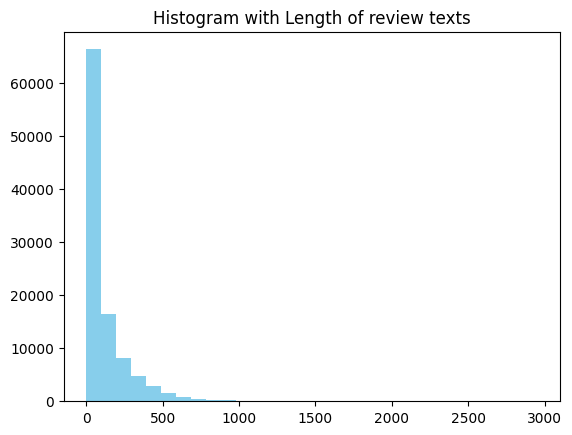

In [8]:
plt.hist(len_of_review_texts, bins=30, color='skyblue')
plt.title('Histogram with Length of review texts')

In [14]:
# extracting the reviews
sentences = reviews['reviewtext']

In [17]:
# SentenceTransformer model which given embedding of dim 384
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

C:\Users\manik\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [19]:
embeds = []
for i in range(len(sentences)):
    print(i, end = '\r')
    embeds.append(model.encode(sentences[i]))

In [78]:
reviews['embeddings'] = [list(i) for i in embeds]

In [93]:
reviews

,reviewerid,asin,reviewtext,summary,helpful,help_percentage,embeddings
0,A29K289KUTT08W,B0031Y9CPG,"Chloe and Zoe may be twins, but they couldn't ...","Short, sweet and smoking hot!","[1, 1]",1.000000,"[0.03024119, -0.28732297, 0.073791474, 0.16252..."
1,A20H8OKGG3HEYE,B0035LDNV4,So good I couldn't put it down. This story sta...,Awesome,"[0, 0]",1.000000,"[0.003320378, 0.022949345, -0.010196304, 0.090..."
2,A3Q278JFRXRBOB,B0038KX8S0,Loved it... very sexy,Five Stars,"[0, 0]",1.000000,"[-0.16691582, 0.0069710314, 0.26197135, 0.0263..."
3,A17QMTJ67OZT2D,B003IWOC24,I want more n need more. I want this Arthur to...,Love,"[0, 0]",1.000000,"[-0.13999316, 0.11178643, -0.24103205, -0.0091..."
4,A1E1LEVQ9VQNK,B003UBTWDM,Note: This review was originally published at ...,Another superb suspense thriller by Eric Chris...,"[31, 37]",0.837838,"[-0.01595805, 0.066376835, -0.3196422, -0.0456..."
...,...,...,...,...,...,...,...
102355,AFC97KDPMJHXG,B00LZKMXBI,** I received an ARC for an honest review**Oka...,3.5 Stars from me...,"[1, 1]",1.000000,"[0.049375683, -0.05256822, -0.15673445, 0.0565..."
102356,ATWW6OLSNNXQ7,B00LZKMXBI,I have read everything H.M. Ward has put out. ...,If you go into this book thinking it will be l...,"[2, 2]",1.000000,"[-0.054319166, -0.22538188, 0.09384776, -0.013..."
102357,A163XZU3HM4EHV,B00LZKMXBI,This book was absolutely perfect! Second Chanc...,I Loved it!!!,"[14, 17]",0.823529,"[-0.17889218, 0.2104188, -0.08642238, 0.243342..."
102358,A20MYFNLY6TGNL,B00LZKMXBI,Amazing! I was crying from page 1 And sweating...,Tears galore!!!!,"[0, 0]",1.000000,"[-0.16470516, 0.07994954, 0.19853128, 0.209138..."


In [66]:
cursor.execute("""alter table reviews 
add column embedding vector(384);""")

In [95]:
# inserting the embeddings
for i in range(reviews.shape[0]):
    cursor.execute(f"""
    UPDATE reviews
    SET embedding = '{reviews['embeddings'][i]}'
    WHERE reviewerid = '{reviews['reviewerid'][i]}' AND asin = '{reviews['asin'][i]}';
    """)